<a href="https://colab.research.google.com/github/kayteeflick/nma_cn_flow_state/blob/pca/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow State PCA

General functions to use in all notebooks. Make a copy of this to start a new type of analysis.




## Imports

In [2]:
#title 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt

## Data Retrieval - spikes

In [3]:
#title Data retrieval - spikes
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

## Functions

In [6]:
# commmon functions

def select_brois(data, brois, data_type, selection=True):
  '''
  Args:
    data: a numpy array of the Steinmetz 2019 data
    brois: a list of brain regions of interest
    data_type: "LFP" or "spikes"
    selection: if True, filters for sessions that contain all brois. If False, filters
        for sessions that contain any of the brois
  Returns:
    an embedded 1-d numpy array, with length = number of filtered session
  '''
  selected_data = np.array([])

  if data_type == "LFP":
    brain_area = "brain_area_lfp"
  elif data_type == "spikes":
    brain_area = "brain_area"

  if selection == True:
    for i in range(len(data)):
      if all(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))
  else:
    for i in range(len(data)):
      if any(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))

  return selected_data

def sel_neurons():
  print('todo')
  return

def spks_to_rate(spks):
  print('todo')
  return

def butter_bandpass_backend(lowcut, highcut, fs, order=6):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter_good_func(data, lowcut, highcut, fs, order=6):
  b, a = butter_bandpass_backend(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, data)
  return y 

def get_behavioral_idx(recording_session):
  '''
  Args:
    alldat: spiking data as loaded in originally 
    recording session: what recording session as an integer you want to pull behavioral indices for 
  Returns:
    series of arrays that you can use to index behavior 
  '''
  response = recording_session['response'] # right - nogo - left (-1, 0, 1)
  vis_right = recording_session['contrast_right'] # 0 - low - high
  vis_left = recording_session['contrast_left'] # 0 - low - high
  gocue_idx = recording_session['gocue']
  rt_idx = recording_session['reaction_time']
  is_correct = np.sign(response)==np.sign(vis_left-vis_right)
  return response, vis_right, vis_left, gocue_idx, rt_idx, is_correct

def concatenate_lfp(brain_area_raw_dat,zeropadsize=0): 
  '''
  Args:
    data: a 2d array of raw brain area LFP should be 2d after you select a specific session and area to pull. 
    zeropadsize: if you'd like to add padding to the concatenation. Default is 0 (no padding)
  Returns:
    1D Array of Concatenated trials for a given brain area recording. 
  '''
  concatenated_data = np.array([])
  N = zeropadsize
  for i in range(len(brain_area_raw_dat)):
    single_trial = brain_area_raw_dat[i,:]
    trial_padded = np.pad(single_trial,(N,N),'constant')
    concatenated_data = np.concatenate([concatenated_data,trial_padded])
  return concatenated_data

def spikes_avg(data):
  '''
  Args:
    data: a single session data frame from Steinmetz 2019 data
  Returns:
    A 2d numpy array of trial averages. Rows are neurons. Column are time step
  '''
  avg = np.mean(data['spks'], axis = 1)

  return avg

def add_avg(data):
  '''
  Adds the trial average to the data structure

  Args: 
    data: a single session dataframe from Steinmetz
  '''
  data["spks_avg"] = spikes_avg(data)
  return data

def multi_add_avg(alldat):
  """
  Adds trial averages to all sessions in the dataframe
  Args:
    alldat: a numpy array of sessions
  """
  for i in range(len(alldat)):
    alldat[i] = add_avg(alldat[i])
  return alldat

def concat_trials(data, bin_start, bin_end):
  """
  Args:
    data: a single session data frame from Steinmetz 2019 data
    bin_start, bin_end: integers indicating which bin to start and end at
  Returns:
    A 2d numpy array of with trials concatenated horizontally with shape N×TK 
    (number of neurons by number of time points times number of trials).
  """   
  NN = data.shape[0]
  X = np.reshape(data[:,:,bin_start:bin_end], (NN,-1))

  return X

def trial_result(data):
  '''
  Args:
    data: a single session data frame
  Returns:
    numpy logical arrarys corresponding to right trials, correct right, incorrect
    right trials, miss right trials, no_go trials
  '''
  # response: right - nogo - left (-1, 0, 1)
  # vis left/right 0 - low - high
  response, vis_right, vis_left, gocue_idx, rt_idx, is_correct = get_behavioral_idx(data)
  ind = {}

  # trial types
  ind["right_go"] = np.array(vis_right > vis_left)
  ind["left_go"] = np.array(vis_left > vis_right)
  ind["nogo"] = np.logical_and(vis_left == 0, vis_right == 0)
  ind["equal"] = np.logical_and(vis_right >0, vis_right == vis_left)
  ind["difficulty"] = np.array(abs(vis_left-vis_right))
  
  # right trials by response
  ind["right_cor"] = np.logical_and(response == -1, vis_right > vis_left)
  ind["right_error"] = np.logical_and(response == 1, vis_right > vis_left)
  ind["right_miss"] = np.logical_and(response == 0, vis_right > vis_left)
  ind["difficulty"] = np.array(vis_right - vis_left)

  # left trials by response
  ind["left_cor"] = np.logical_and(response == 1, vis_right < vis_left)
  ind["left_error"] = np.logical_and(response == -1, vis_right < vis_left)
  ind["left_miss"] = np.logical_and(response == 0, vis_right < vis_left)

  # nogo trials by response
  ind["nogo_cor"] = np.logical_and(response == 0, ind["nogo"])
  ind["nogo_error"] = np.logical_and(response != 0, ind["nogo"])

  return ind

def get_high_firing_spikes(spike_data, min_rate, sr=100):
  '''
  Takes spike data and returns only the neurons with a high enough firing rate
  averaged across all trials/time

  Parameters
  --------------------------------
  spike_data : 3d array of spikes with dimensions (neurons, trials, time)
  min_rate : The firing rate to filter above (in spikes/sec)
  sr : sampling rate of data

  Returns
  --------------------------------
  spikes_subset : 3d array of spikes with dimensions (neurons (filtered), trials, time)
  '''
  spike_counts = np.sum(np.reshape(spike_data, (spike_data.shape[0], -1)), axis=1)
  total_time = spike_data.shape[1] * spike_data.shape[2] / sr
  spike_rate = spike_counts / total_time
  spikes_subset = spike_data[spike_rate > min_rate]
  index = [spike_rate > min_rate]

  return spikes_subset, index

## PCA Functions

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

def z_score(X):
    # X: ndarray, shape (n_samples, n_features)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X)
    return Xz

def plot_variance_explained(variance_explained, title = None):
  """
  Plots eigenvalues.
  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC
  Returns:
    Nothing.
  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  if title != None:
    plt.title(title)
  plt.show()


pal = sns.color_palette('husl', 9)
%config InlineBackend.figure_format = 'svg'

def add_stim_to_plot(ax, start_stim, end_stim, qshade_alpha = 0.2, lines_alpha = 0.8):
    ax.axvspan(start_stim, end_stim, alpha=shade_alpha,
               color='gray')
    ax.axvline(start_stim, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(end_stim, alpha=lines_alpha, color='gray', ls='--')
    
def add_orientation_legend(ax, trial_types):
    custom_lines = [Line2D([0], [0], color=sns.color_palette('husl', 9)[k], lw=4) for
                    k in range(len(trial_types))]
    labels = ['{}'.format(t) for t in trial_types]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0,0,0.9,1])

def run_pca(data, plot_var = True, title = None):
  '''
  Centers and normalizes data, performs PCA, returns pca and components. 
  Plots variance explained.

  Arg:
    data: numpy array, shape N * S, neurons by samples
  '''
  # center and normalize firing rates
  X = z_score(data.T).T

  # perform PCA
  pca = PCA()
  X_p = pca.fit_transform(X.T).T

  if plot_var:
    var = np.cumsum(pca.explained_variance_ratio_)
    plot_variance_explained(var, title)

  return pca, X_p

def plot_pca_trial(components, num_components, time, trial_size, trial_types):
  fig, axes = plt.subplots(1, num_components, figsize=[num_components*3, 2.8], sharey='row')
  for comp in range(num_components):
      ax = axes[comp]
      for kk, type in enumerate(trial_types):
          x = components[comp, kk * trial_size :(kk+1) * trial_size]
          x = gaussian_filter1d(x, sigma=3)
          ax.plot(time, x, c=pal[kk])
      ax.axvline(0, alpha=.8, color='gray', ls='--')
      #ax.axvline(end_stim, alpha=lines_alpha, color='gray', ls='--')
      ax.set_ylabel('PC {}'.format(comp+1))
  add_orientation_legend(axes[num_components-1], trial_types)
  axes[1].set_xlabel('Time (ms)')
  sns.despine(fig=fig, right=True, top=True)
  #plt.tight_layout(rect=[0, 0, 0.9, 1])

In [ ]:
print(fil_dat[1].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


## Select Data

In [ ]:
fil_dat = select_brois(alldat, ['CA1', 'SUB', 'PL'],"spikes", selection=True)
brois = ['VISp', 'VISam', 'LGd' ,'CA1', 'SUB', 'PL', 'ACA', 'MD', 'MOs']

In [ ]:
session_count = 0
for i in range(len(fil_dat)):
  print(f'{fil_dat[i]["mouse_name"]} {fil_dat[i]["date_exp"]}: {np.unique(fil_dat[i]["brain_area"])}\n'
        f'{len(fil_dat[i]["brain_area"])} neurons, {len(fil_dat[i]["response"])} sessions\n')
  

Forssmann 2017-11-02: ['ACA' 'CA1' 'DG' 'MOs' 'OLF' 'ORB' 'PL' 'SUB' 'VISa' 'root']
1077 neurons, 254 sessions

Hench 2017-06-15: ['CA1' 'CA3' 'DG' 'ILA' 'LD' 'LP' 'LSr' 'MOs' 'PL' 'PO' 'SUB' 'TT' 'VISa'
 'VISp' 'root']
1156 neurons, 250 sessions

Lederberg 2017-12-05: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']
698 neurons, 340 sessions

Theiler 2017-10-11: ['ACA' 'CA1' 'DG' 'ILA' 'LP' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']
1348 neurons, 343 sessions



In [29]:
# select session
dat = alldat[11]

# get behavioral indices
behabioral_idx = trial_result(dat)

# filter to right sessions
right_trials = dat["spks"][:, ind["right_go"], :]

# filter to neurons with 1hz average firing rate
right_trials, brain_idx = get_high_firing_spikes(right_trials,1, sr=100)


In [31]:
brain_area_right = dat['brain_area'][brain_idx]

for area in np.unique(dat['brain_area']):
  print(f'{area}: {np.sum([dat["brain_area"] == area])} neurons -> {np.sum([brain_area_right == area])} neurons')


ACA: 16 neurons -> 3 neurons
CA1: 50 neurons -> 23 neurons
DG: 65 neurons -> 38 neurons
LGd: 11 neurons -> 8 neurons
LH: 18 neurons -> 16 neurons
MD: 126 neurons -> 98 neurons
MOs: 6 neurons -> 0 neurons
PL: 56 neurons -> 14 neurons
SUB: 105 neurons -> 65 neurons
VISam: 79 neurons -> 44 neurons
VISp: 66 neurons -> 24 neurons
root: 100 neurons -> 56 neurons


In [32]:
print(right_trials.shape)

(389, 111, 250)


## Comparing Trial Concatenated and Trial Averaged PCA

(389, 9990)


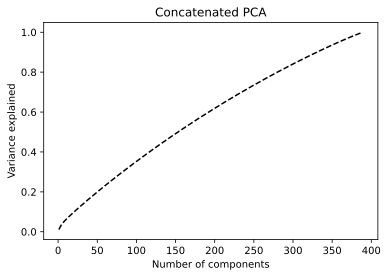

In [47]:
# structure data for PCA - trial concatenated
X_long = concat_trials(right_trials, 41, 131)
print(X_long.shape)

# perform PCA
pca_long, comp_long = run_pca(X_long, title = "Concatenated PCA")

In [35]:
## structure data for PCA - trial averaged

# create index that will index into the already preselected right trials
trial_dif = ind["difficulty"][ind["right_go"]]

# get trial types
trial_types = np.unique(trial_dif)

# create neuron averages for each trial type
trial_averages = []
for difficulty in trial_types:
  
  trial_averages.append(np.mean(right_trials[:,np.array(trial_dif == difficulty),41:131], axis = 1))

# stack for PCA
X_avg = np.hstack(trial_averages)

print(f'Number of neurons: {X_avg.shape[0]}, '
      f'Number of samples: {X_avg.shape[1]}')

Number of neurons: 389, Number of samples: 360


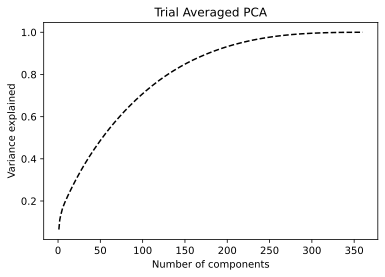

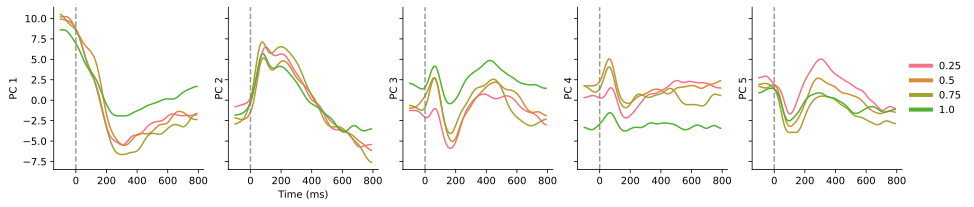

In [48]:
# Run PCA
pca_avg, comp_avg  = run_pca(X_avg, title = "Trial Averaged PCA")

# Plot PCA components by trial type
plot_pca_trial(components= comp_avg, num_components = 5, time = np.arange(-100, 800, 10), trial_size = 90, trial_types =trial_types)

## PCA by Brain Region

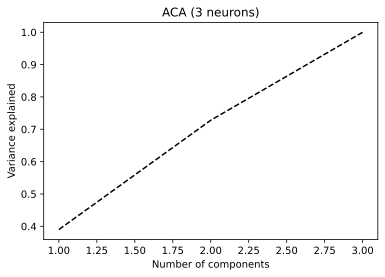

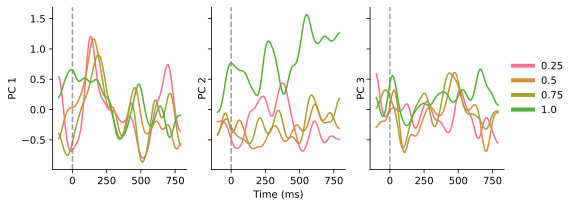

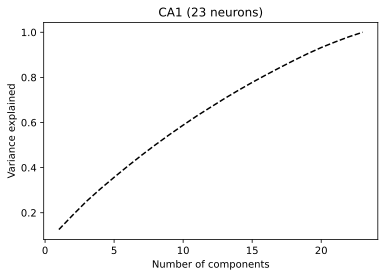

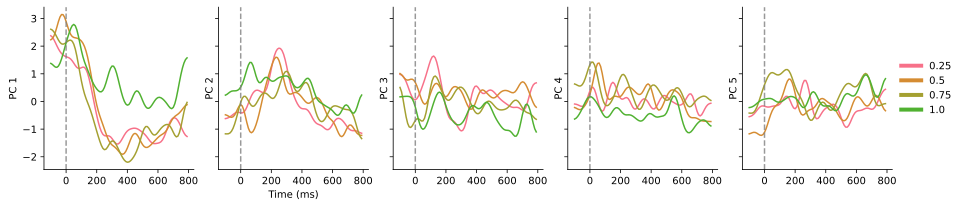

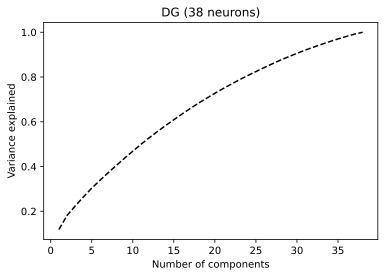

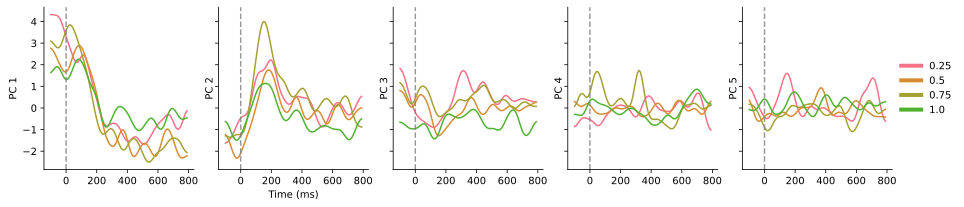

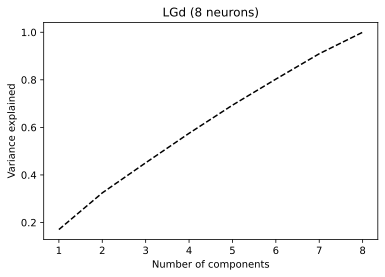

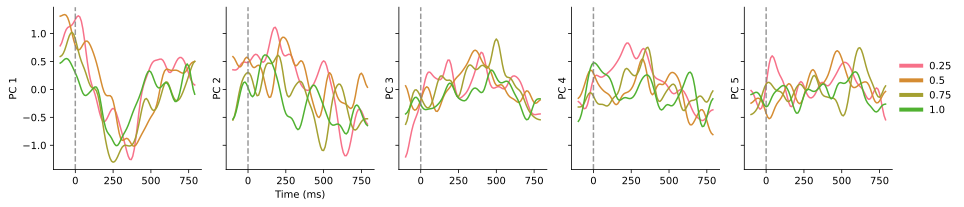

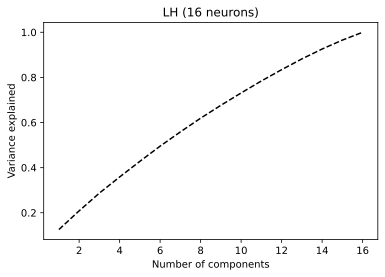

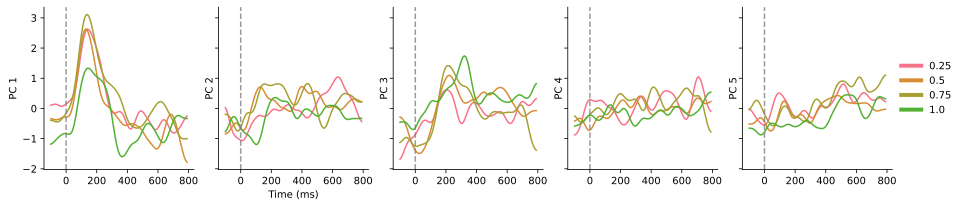

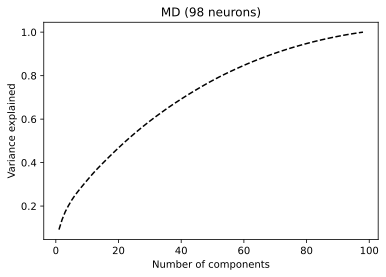

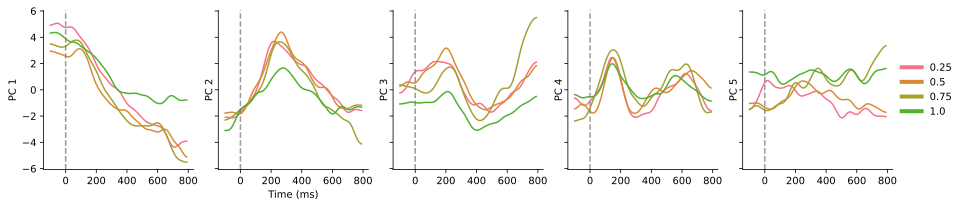

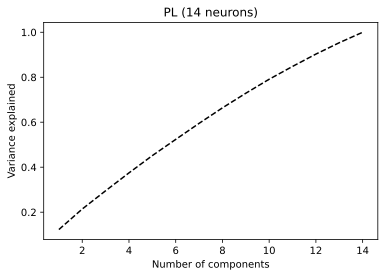

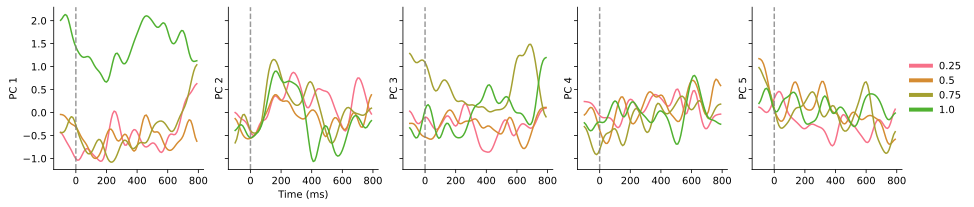

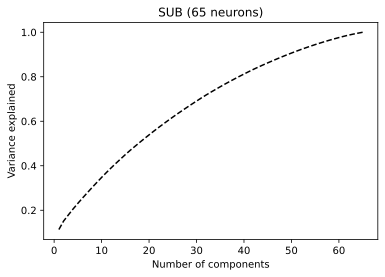

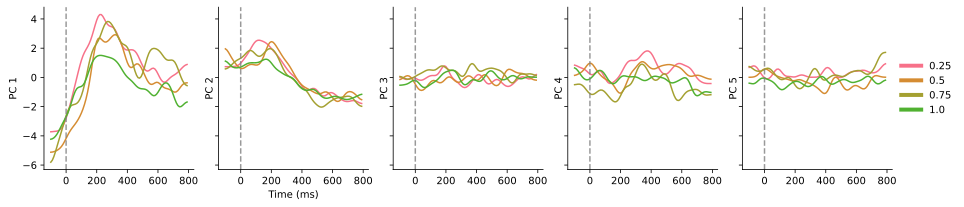

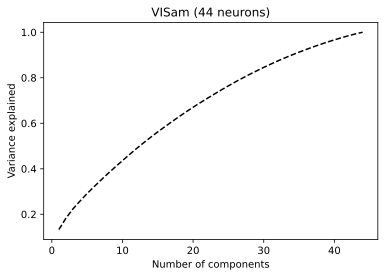

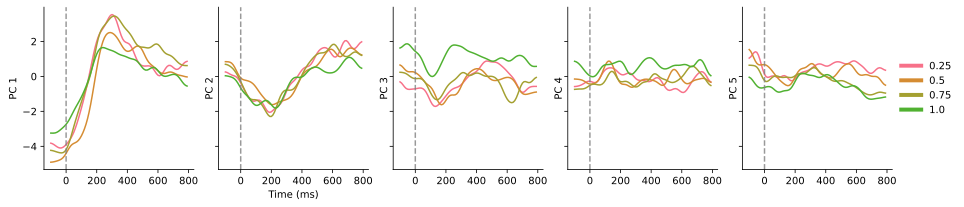

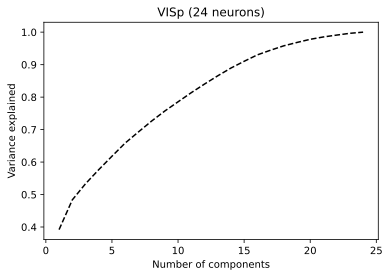

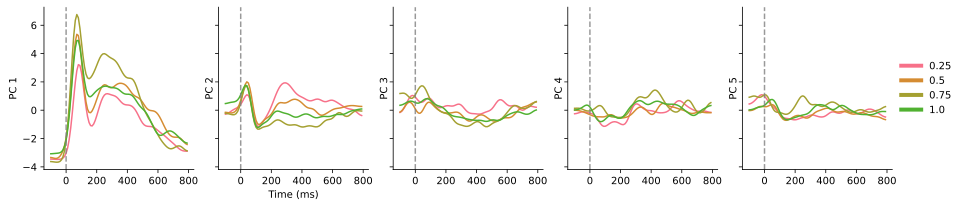

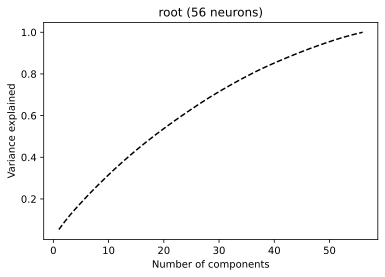

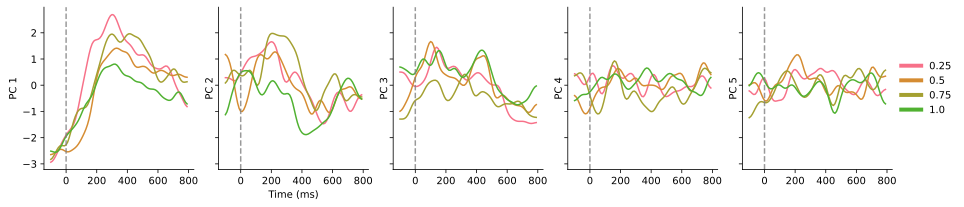

In [56]:
for area in np.unique(brain_area_right):
  data = X_avg[brain_area_right == area]
  #print(f'{area}: {data.shape[0]} neurons, {data.shape[1]} samples')
  # Run PCA
  pca_avg, comp_avg  = run_pca(data, title = (f'{area} ({data.shape[0]} neurons)'))
  # Plot PCA components by trial type
  if len(comp_avg) == 3:
    plot_pca_trial(components= comp_avg, num_components = 3, time = np.arange(-100, 800, 10), trial_size = 90, trial_types =trial_types)
  else:
    plot_pca_trial(components= comp_avg, num_components = 5, time = np.arange(-100, 800, 10), trial_size = 90, trial_types =trial_types)
